---
authors:
  - name: "John B. DeSanto"
    id: johnbdesanto
    affiliations:
      - id: uw-ess
    orcid: "0000-0003-4997-364X"
    github: johnbdesanto
---

# Exercise 2: Travel Time Residuals and Residual Flagging

## Introduction

This exercise is intended to introduce the concept of GNSS-Acoustic travel time residuals, how they can introduce bias into a GNSS-A positioning inversion, and how we can use them to refine an array position.

A more formal definition of GNSS-A residuals may be found in the [GNATSS documentation](https://gnatss.readthedocs.io/en/latest/gnssa_derivation.html), but the short version is that these residuals are the difference between two two-way travel time (TWTT) estmates between the sea surface transducer and the seafloor transponders, that measured in the field and that modelled after the fact when preparing the positioning inversion. 

The model used to estimate TWTTs is generally some flavor of an acoustic raytracing operation between the sea surface transducer and the seafloor transponder, and relies on information about the sound velocity structure of the water column as well as the position of the transducer and seafloor transponders. In principle, if we had perfect knowledge of these components we should be able to perfectly replicate the measured TWTT, but this is never achieved in practice because the ocean is dynamic, the position of the transducer cannot be perfectly estimated with GNSS, and the transponders move with the seafloor away from their initial positions (albeit slowly). From a different perspective, if we can minimize the signal in the residuals contributed by the oceanographic and transducer positioning uncertainties then the remaining varitations should be the result of seafloor transponder displacements.

The GNSS-A array positioning performed by GNATSS is based upon this observation, but in order to work it depends on the user minimizing the contributions of undesired signals to the residuals through a process called residual flagging.

## Starting a GNATSS Inversion

In this exercise we will consider data collected at a GNSS-Acoustic array NCB1 offshore Coos Bay, OR, from 2018-2024 for the Near-Trench Community Geodesy Experiment. The inversions will be managed by the configuration files and saved in output directories, one for each year the array was surveyed during. The configuration files have been pre-made with all of the required information and should not need to be modified.

To expedite the processing, we have already generated `gps_solution.csv` files for each survey using the posfilter module of GNATSS, so users will only need to run the solver module when processing these data. In fact, posfilter parameters are missing from the configuration files, as are the required data files for the posfilter, so users will be required to skip the posfilter during this exercise. The simplest way of doing this is to invoke the `--solver` flag if running GNATSS from the command line, in python the user may set `skip_posfilter=True` when executing `run_gnatss()`.

We will start by considering the data collected during the most recent survey in 2024. If you are running GNATSS on the command line, process the data using the command `gnatss run --solver ../data/exercise-2/NCB1_2024_config.yaml`. Otherwise, we may execute the equivalent in python with the following:

In [1]:
from gnatss.main import run_gnatss

In [2]:
# Set input variables

config_yaml = "../data/exercise-2/NCB1_2024_config.yaml"
skip_posfilter = True

Starting GNATSS ...
Gathering sound_speed at ../data/exercise-2/ctd/CTD_NCB1_Ch_Mi
Gathering gps_solution at ../data/exercise-2/output_2024/gps_solution.csv
Loading sound_speed from ../data/exercise-2/ctd/CTD_NCB1_Ch_Mi
Loading gps_solution from ../data/exercise-2/output_2024/gps_solution.csv
Loading deletions from ../data/exercise-2/output_2024/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1481.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean=1481.704 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...
Perform solve

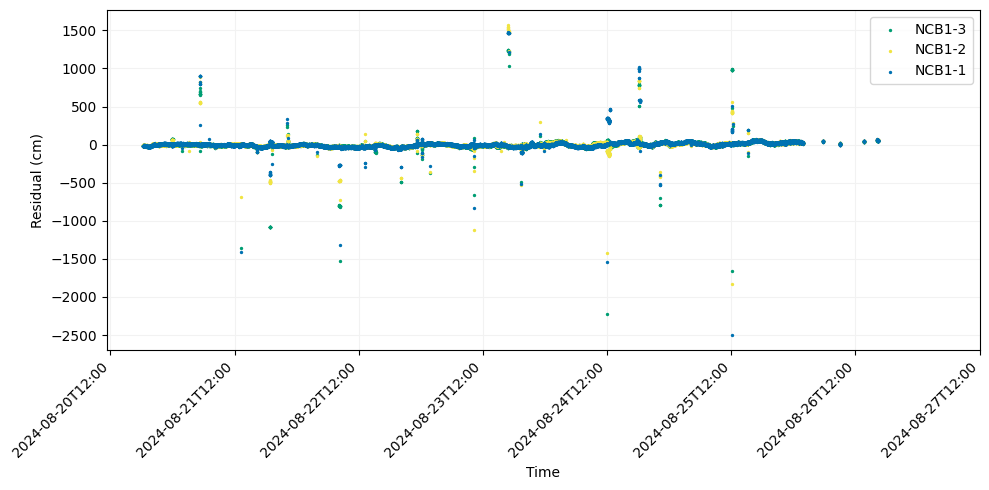

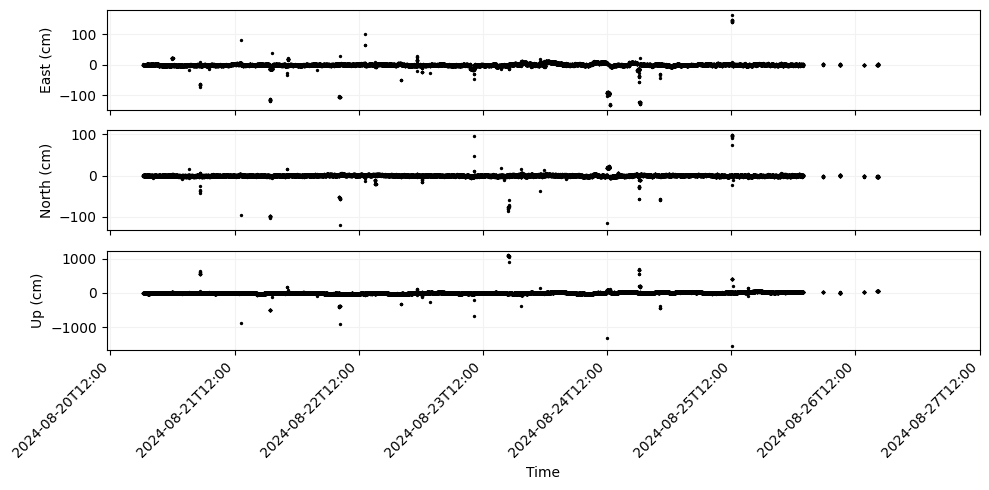

In [3]:
output = run_gnatss(
    config_yaml,
    skip_posfilter=skip_posfilter
)

Let's talk briefly about what we are looking at in these plots.

The upper figure, saved as `residuals.png`, is a plot of the TWTT residuals. These residuals have been converted from units of seconds to units of centimeters by mulitplying them by the harmonic mean sound velocity. There is one time series of residuals for each transponder (so 3 in total for this array) and these time series are all plotted on the same axis. Note that "0 cm" is relative here and defined by the average of the three time series.

The lower figure, saved as `residuals_enu_components.png` is a rough estimate of the offset of the array center over the span of the survey. It is calculated by assuming the TWTT residuals are vectors oriented along the ray path from the sea surface above the array center to the indivdual transponders, decomposing these vectors into E, N, and U components, and averaging them.

We can see in these plots that most of the signal in the residuals is focussed around 0 cm, so we are doing a decent job of predicting the TWTTs. However, there are a number of "outliers" focussed along vertical lines that correspond to large offsets in the ENU plot. These are data artifacts, usually the result of GNSS cycle slips but in rare and extreme cases can be improperly recorded travel times (such as if a digit is dropped from the recording). Because these points are clearly non-physical measurements, we should remove them from the inversion in order to prevent them from biasing our result.

## Flagging Residuals with --residual-limit

GNATSS has the funtionality to identify and remove these outlier residuals using a few different strategies. Two means that a user can set are a distance threshold from the center of the array with `--distance-limit` and by setting a `gps_sigma_limit` in the configuration file. However, the primary means for flagging residuals is to set an *outlier threshold*, which directs GNATSS to flag any TWTT residual for removal if it has a magnitude greater than the threshold. Using the example above, we want to remove the outliers that are reflected in the vertical residual spikes but not the residuals close to the main time series near 0. We should be able to do this by setting an outlier threshold of a few hundred cm, which can be done by re-running the previous GNATSS inversion using the `--residual-limit XXX` flag with `XXX` being the desired threshold in cm. 

In python:

Starting GNATSS ...
Gathering sound_speed at ../data/exercise-2/ctd/CTD_NCB1_Ch_Mi
Gathering gps_solution at ../data/exercise-2/output_2024/gps_solution.csv
Loading sound_speed from ../data/exercise-2/ctd/CTD_NCB1_Ch_Mi
Loading gps_solution from ../data/exercise-2/output_2024/gps_solution.csv
Loading deletions from ../data/exercise-2/output_2024/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1481.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean=1481.704 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...
Perform solve

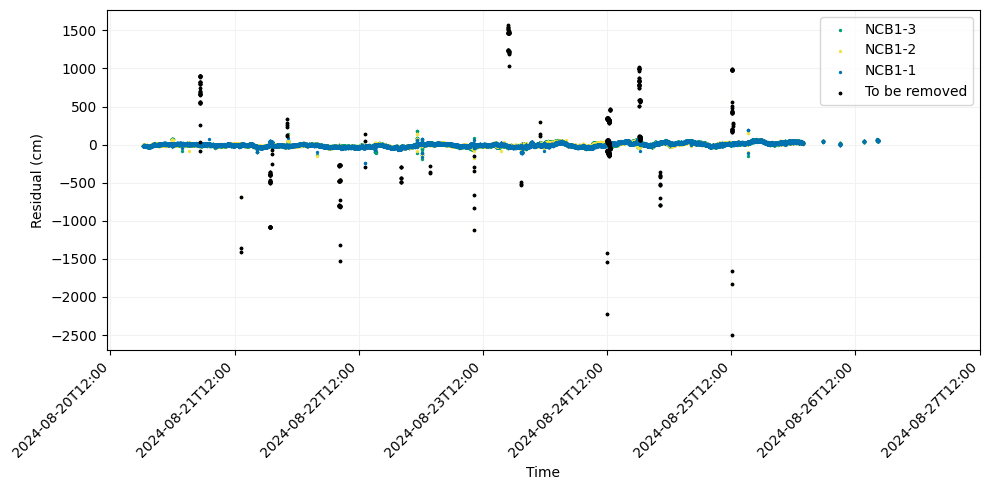

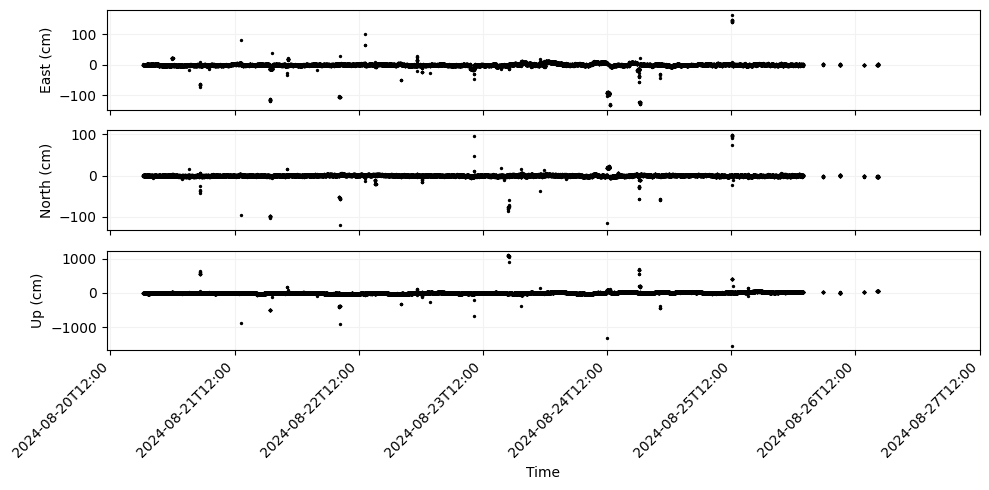

In [4]:
distance_limit = 150
residual_limit = 250

output = run_gnatss(
    config_yaml,
    distance_limit=distance_limit,
    residual_limit=residual_limit,
    skip_posfilter=skip_posfilter
)

If you look closely at this new solution, you will notice that it hasn't actually changed yet but in the residual plot a number of residuals have been highlighted as "To be removed". This allows the user to preview flagged residuals in order to verify that nothing they want to keep will be accidentally removed.

The flagged residuals have been saved in a new output file called `outliers.csv`, which contains a record of time stamps and magnitudes for each flagged residual. This file is updated each time GNATSS is run, so if there are residuals flagged that you do not want to remove simply runng GNATSS again with a different outlier threshold will update this file.

If the flagged residuals are satisfactory you can remove them from the inversion by running GNATSS with the `--remove-outliers` flag. This concatenates any residuals in the `outliers.csv` file to a new file, `deletions.csv`. GNATSS automatically reads the deletions file when run and will ignore any residuals with time stamps logged in that file. **This is a non-destructive operation**, so if for some reason you wish to include data previously removed back into the inversion you do not need to re-do any GNSS-A pre-processing; simply alter or remove the deletions file and you can re-interpret the residuals as needed.

Let's go ahead and remove the residuals that have been flagged.

Starting GNATSS ...
Gathering sound_speed at ../data/exercise-2/ctd/CTD_NCB1_Ch_Mi
Gathering gps_solution at ../data/exercise-2/output_2024/gps_solution.csv
Loading sound_speed from ../data/exercise-2/ctd/CTD_NCB1_Ch_Mi
Loading gps_solution from ../data/exercise-2/output_2024/gps_solution.csv
Loading deletions from ../data/exercise-2/output_2024/
Found /Users/johndesanto/Documents/gnatss-workshop/docs/../data/exercise-2/output_2024/outliers.csv file. Including into cuts...
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1481.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean

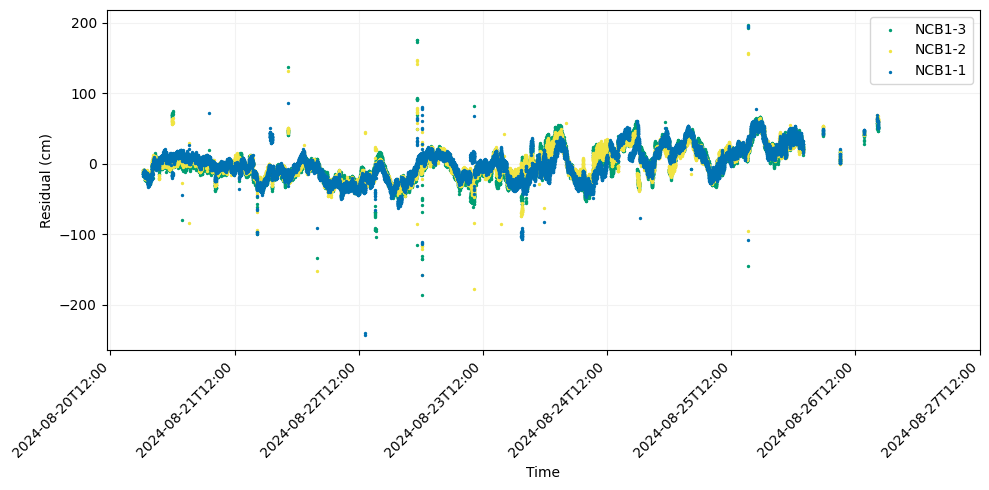

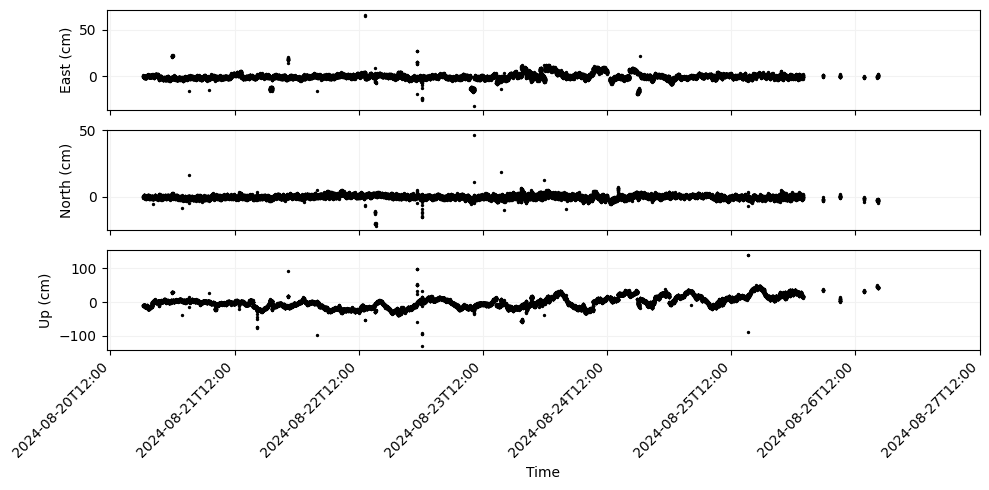

In [5]:
output = run_gnatss(
    config_yaml,
    distance_limit=distance_limit,
    remove_outliers=True,
    skip_posfilter=skip_posfilter
)

## Flagging Residuals with --residual-range-limit

We can see quite a bit more detail in the residuals now that we have removed some outliers. There is a pretty clear oceanograhpic signal, but believe it or not this is not necessarily a problem. A fundamental assumption of the GNATSS inversion is that the ocean behaves like a horizontally layered medium with any variation occuring in the upper water column above the thermocline. If this is the case, all of the oceanographic variation will occur in a section of the water column where the acoustic rays to each transponder are geometrically close to each other as long as we survey at the array center. The result is that each ping sees a similar oceanographic delay to each transponder and the residuals plot nearly on top of each other, and as long as this holds the oceanographic signal will be interpreted as a vertical offset rather than a horizontal offset. (This is why we can achieve cm-level horizontal positioning accuracy but worse or even unconstrained vertical positioning accuracy.)

However, there are also still some of the outliers from cycle slips and these outliers overlap with the "main" residual time series at some points. Because of this, an outlier threshold is not appropriate to remove all of these points. An alternative tool in GNATSS for outlier flagging is to set a `--residual-range-limit` flag. This measures the difference between the minimum and maximum residual for each epoch, if the range is greater then the threshold that epoch is flagged. This routine takes advantage of the key point described above that the signals we want to remove are those where the residual time series for each transponder diverge, since that is evidence of our fundamental assupmtions of the ocean structure start to break down. Similar to the `--residual-limit` flag, the `--residual-range-limit XXX` flag takes a value in cm as input.

Let's demonstrate this:

Starting GNATSS ...
Gathering sound_speed at ../data/exercise-2/ctd/CTD_NCB1_Ch_Mi
Gathering gps_solution at ../data/exercise-2/output_2024/gps_solution.csv
Loading sound_speed from ../data/exercise-2/ctd/CTD_NCB1_Ch_Mi
Loading gps_solution from ../data/exercise-2/output_2024/gps_solution.csv
Loading deletions from ../data/exercise-2/output_2024/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1481.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean=1481.704 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...
Perform solve

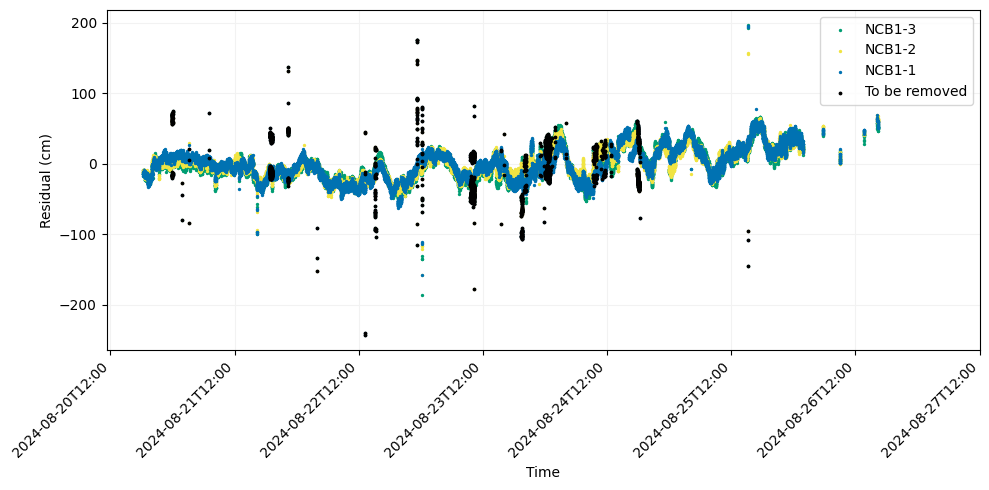

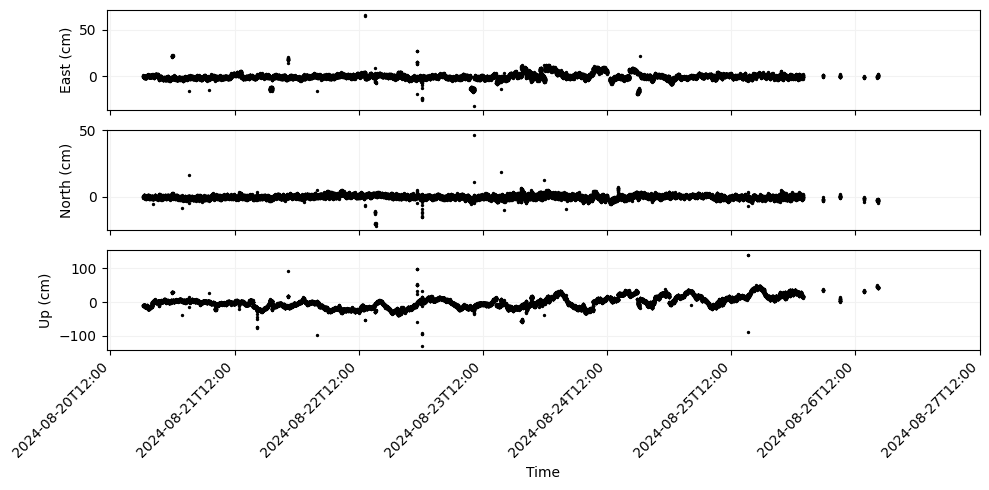

In [6]:
residual_range_limit = 40

output = run_gnatss(
    config_yaml,
    distance_limit=distance_limit,
    residual_range_limit=residual_range_limit,
    skip_posfilter=skip_posfilter
)

We can see that much of the cycle slips have now been flagged as well as some places where the time series diverged. Once again, we can remove these outliers with the `--remove-outliers` flag.

Starting GNATSS ...
Gathering sound_speed at ../data/exercise-2/ctd/CTD_NCB1_Ch_Mi
Gathering gps_solution at ../data/exercise-2/output_2024/gps_solution.csv
Loading sound_speed from ../data/exercise-2/ctd/CTD_NCB1_Ch_Mi
Loading gps_solution from ../data/exercise-2/output_2024/gps_solution.csv
Loading deletions from ../data/exercise-2/output_2024/
Found /Users/johndesanto/Documents/gnatss-workshop/docs/../data/exercise-2/output_2024/outliers.csv file. Including into cuts...
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1481.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean

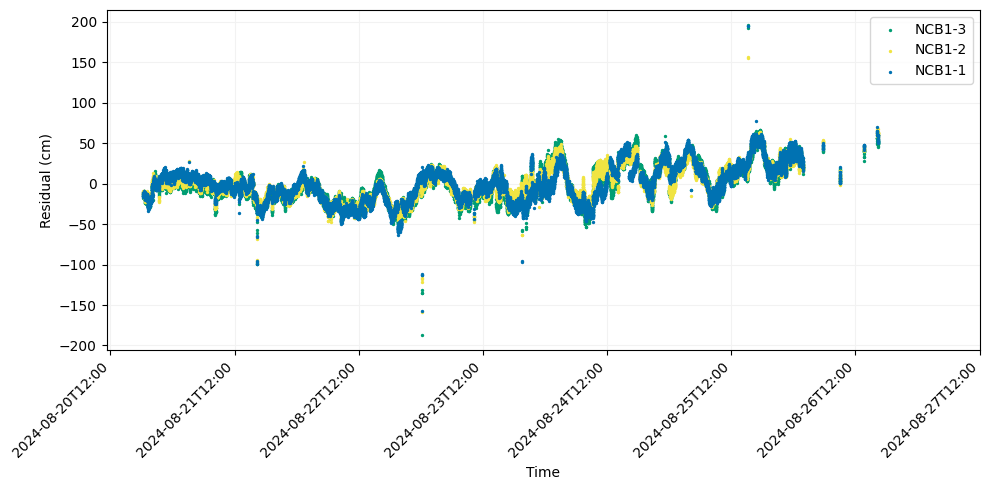

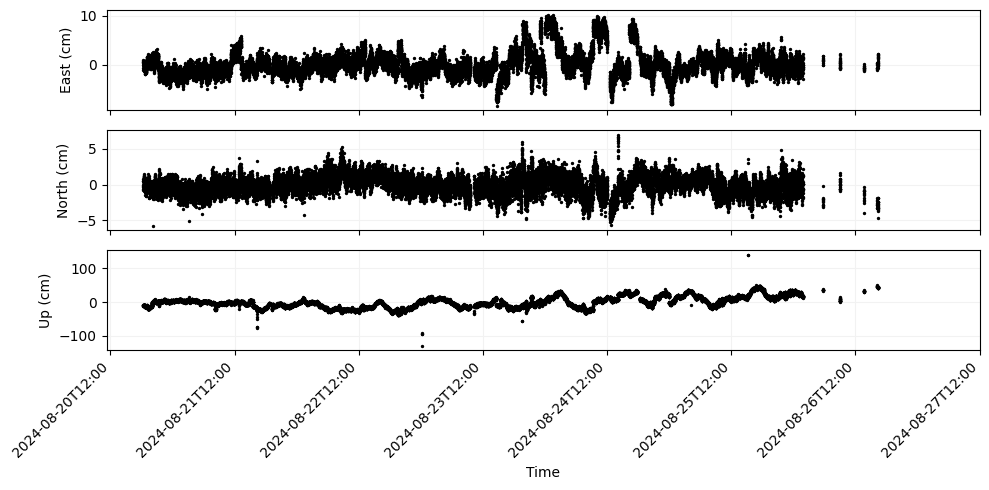

In [7]:
output = run_gnatss(
    config_yaml,
    distance_limit=distance_limit,
    remove_outliers=True,
    skip_posfilter=skip_posfilter
)

We've now made significant progress with this particular data set. In general, I prefer to flag to a standard where the outlier threshold is such that it borders the main residual time series (this varies according to the individual data set) and the residual range threshold is 20 cm.

However, it is worth noting that the mean of the residuals changes as you remove outliers, particularly large outliers. This shifts the relative position of "0 cm", so I prefer to flag conservatively over many iterations as I approach these standards in order to minimize the risk of removing good data from the inversion.

## Further Exercises

1) Continue flagging the data in the 2024 NCB1 survey until you are satisfied with the results.

In [ ]:
output = run_gnatss(
    config_yaml,
    distance_limit=distance_limit,
    residual_limit=,
    residual_range_limit=,
    skip_posfilter=skip_posfilter
)

2) There are four other data sets collected at this array between the years 2018-2023. Try to process these data and flag them on your own. Like with the 2024 survey, each of these data sets has already been preprocessed so you only have to run the GNATSS solver module.

In [ ]:
config_yaml = "../data/exercise-2/NCB1_2023_config.yaml"

output = run_gnatss(
    config_yaml,
    distance_limit=distance_limit,
    residual_limit=,
    residual_range_limit=,
    skip_posfilter=skip_posfilter
)